In [1]:
!pip install --user pydot

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15419060170660111321, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10585813761493709623
 physical_device_desc: "device: XLA_CPU device"]

In [2]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
filepath = 'saved_models/LSTM/5epoch_test.h5'
model = keras.models.load_model(filepath)












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




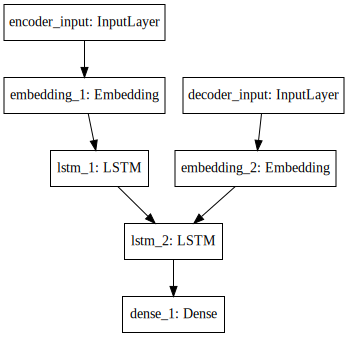

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 256)      1699328     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 256)      2247168     decoder_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [6]:
#define encoder
encoder_model = Model(inputs=model.input[0], #encoder_input
                      outputs=model.get_layer('lstm_1').output[1:]) #enconder lstm hidden state

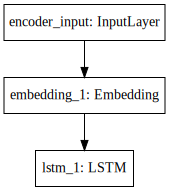

In [7]:
SVG(model_to_dot(encoder_model).create(prog='dot', format='svg'))

In [11]:
#define decoder
embedding_dim = 256
units = 1024
vocab_tar_size = model.get_layer('dense_1').weights[1].shape.as_list()[0]

decoder_word_input = Input(shape=(1,),name='decoder_input')
decoder_input_embedding = Embedding(input_dim=vocab_tar_size, 
                                    output_dim=embedding_dim,
                                    weights=model.get_layer('embedding_2').get_weights())(decoder_word_input)


decoder_state_input_h = Input(shape=(units,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(units,), name='decoder_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = LSTM(units, 
                    return_sequences=False, 
                    return_state=True,
                    weights=model.get_layer('lstm_2').get_weights())
decoder_output, state_h, state_c = decoder_lstm(decoder_input_embedding,
                                                initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_dense = Dense(vocab_tar_size, 
                      activation='softmax',
                      weights=model.get_layer('dense_1').get_weights())
decoder_output = decoder_dense(decoder_output)

decoder_model = Model(inputs=[decoder_word_input] + decoder_states_inputs,
                      outputs=[decoder_output] + decoder_states)

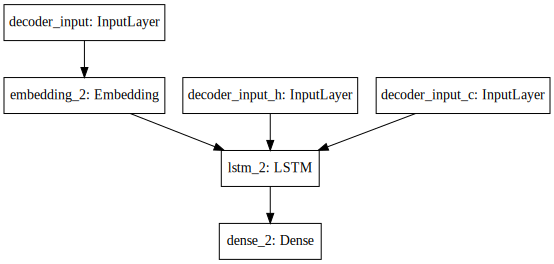

In [12]:
SVG(model_to_dot(decoder_model).create(prog='dot', format='svg'))

In [13]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 256)       2247168     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
lstm_2 (LS

In [14]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [15]:
def create_dataset(path, num_examples):
    with open(path) as f:
        word_pairs = f.readlines()
    word_pairs = [preprocess_sentence(sentence) for sentence in word_pairs]

    return word_pairs[:num_examples]

In [16]:
# データの読み込み
path_train_en = 'small_parallel_enja/train.en'
path_train_ja = 'small_parallel_enja/train.ja'
en = create_dataset(path_train_en, None)
ja = create_dataset(path_train_ja, None)
print(en[-1])
print(ja[-1])

<start> he thought irritably . <end>
<start> 彼 は いらだ ち ながら 思 っ た 。 <end>


In [17]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [18]:
def tokenize(lang):
    #これはなくす。
    #学習済みw2vをembeddingにつかうので
    lang_tokenizer = keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [19]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    lang = create_dataset(path, num_examples)

    tensor, lang_tokenizer = tokenize(lang)

    return tensor, lang_tokenizer

In [20]:
# 単語へのIDの割り振りとID列への変換
# このサイズのデータセットで実験
num_examples = None
input_tensor, inp_lang = load_dataset(path_train_en, num_examples)
target_tensor, targ_lang = load_dataset(path_train_ja, num_examples)
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [21]:
max_length_targ

18

In [22]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [23]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [24]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
2 ----> <start>
7 ----> to
522 ----> understand
599 ----> someone
9 ----> is
7 ----> to
297 ----> love
599 ----> someone
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
303 ----> だれ
22 ----> か
9 ----> を
461 ----> 理解
39 ----> する
34 ----> こと
5 ----> は
31 ----> 、
27 ----> その
51 ----> 人
9 ----> を
353 ----> 愛
39 ----> する
34 ----> こと
23 ----> だ
4 ----> 。
3 ----> <end>


In [124]:
def decode_sequence(input_seq, targ_lang, max_length_targ):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    vocab_tar_size = np.array(list(targ_lang.index_word.keys())).max()
    inp_batch_size = len(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((inp_batch_size, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0] = targ_lang.word_index['<start>']
    
    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = np.zeros((inp_batch_size, max_length_targ))
    
    for i in range(max_length_targ):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens,axis=1) #array of size [inp_batch_size, 1]

        decoded_sentence[:,i] = sampled_token_index

        # Update the target sequence (of length 1).
        target_seq = np.zeros((inp_batch_size, 1))
        target_seq[:, 0] = sampled_token_index

        # Update states
        states_value = [h, c]


    return decoded_sentence    

decode_sequence(input_tensor_val[0:5],targ_lang,max_length_targ)

array([[ 42.,   5.,  46.,   9.,  16.,  11.,   6.,  21.,  19.,  22.,   4.,
          3.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 18.,   5.,  42.,  10., 161.,   7., 390.,  12.,  19.,   4.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 15.,   5.,  27.,  67.,   9., 265.,   8.,   4.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 24.,   5.,  27.,  67.,   9., 265.,   8.,   4.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 15.,  10.,  65.,   5.,  76., 189.,  43.,   8.,   4.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [110]:
for i,j in enumerate(range(10)):
    print(i,j)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [94]:
len(input_tensor_val[2:4])

2

In [48]:
targ_lang.word_index['<start>']

2

In [119]:
targ_lang.word_index['<end>']

3

In [84]:
targ_lang.index_word[18]

'私'

In [27]:
convert(inp_lang, input_tensor_val[0])

2 ----> <start>
19 ----> have
8 ----> you
262 ----> finished
664 ----> writing
36 ----> your
5557 ----> thesis
12 ----> ?
3 ----> <end>


In [29]:
convert(targ_lang, target_tensor_val[0])

2 ----> <start>
2050 ----> 論文
9 ----> を
143 ----> 書
37 ----> き
265 ----> 終え
21 ----> ま
16 ----> し
8 ----> た
22 ----> か
4 ----> 。
3 ----> <end>


In [ ]:
# 必要に応じて修正
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)